<a href="https://colab.research.google.com/github/anapvalle/IAMA_aulas/blob/main/aula7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aulas anteriores

In [1]:
# execute this for the 1st time
#!pip install -r example-requirements.txt

# download file
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # colab

# and place in folder data/

--2024-09-10 22:32:36--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.12
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat’

data3SS2009.mat     100%[===================>] 255.24M  10.8MB/s    in 19s     

2024-09-10 22:32:56 (13.3 MB/s) - ‘data3SS2009.mat’ saved [267634147/267634147]



In [2]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

In [3]:
fname = join(getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

#y
y_target = y>9 #maior que nove apresenta dano
y_target

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

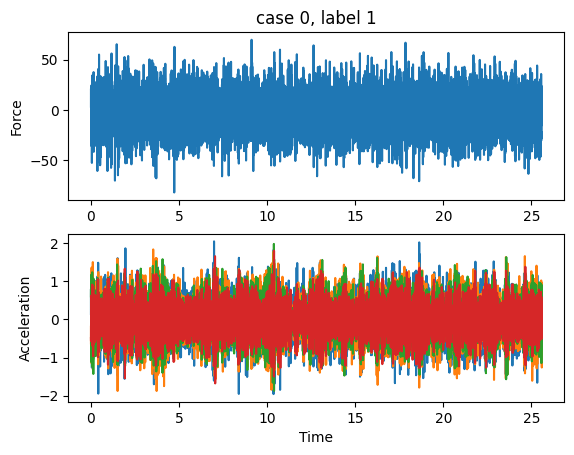

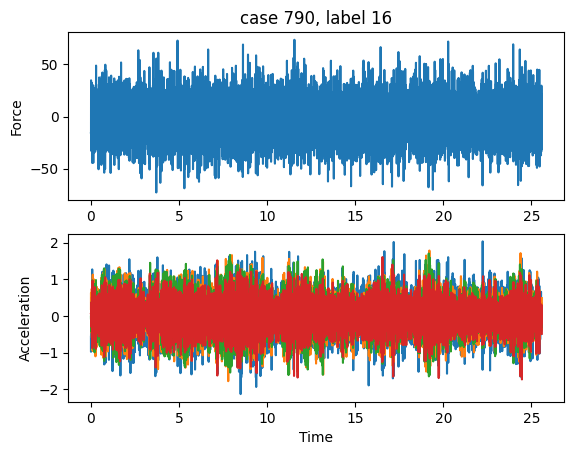

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [5]:
Ch2.shape

(8192, 850)

##Obtendo X1

In [6]:
from statsmodels.tsa.ar_model import AutoReg
na=30

FeatARCh2 = []
FeatARCh3 = []
FeatARCh4 = []
FeatARCh5 = []

for i in range(Nc):
  res1 = AutoReg(Ch2[:,i], lags = na, trend = 'n').fit()
  res2 = AutoReg(Ch3[:,i], lags = na, trend = 'n').fit()
  res3 = AutoReg(Ch4[:,i], lags = na, trend = 'n').fit()
  res4 = AutoReg(Ch5[:,i], lags = na, trend = 'n').fit()

  FeatARCh2.append(res1.params)
  FeatARCh3.append(res2.params)
  FeatARCh4.append(res3.params)
  FeatARCh5.append(res4.params)

FeatARCh2 = np.array(FeatARCh2)
FeatARCh3 = np.array(FeatARCh3)
FeatARCh4 = np.array(FeatARCh4)
FeatARCh5 = np.array(FeatARCh5)

X1 = np.concatenate([FeatARCh2, FeatARCh3,FeatARCh4,FeatARCh5], axis = 1)

X1.shape #850x120

(850, 120)

##Dividindo em dados de treino e teste

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y_target, test_size=0.4, random_state=42)

In [8]:
X_train.shape

(510, 120)

##Aplicação do modelo softmax

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X_train,y_train)

yhat = model.predict(X_test)

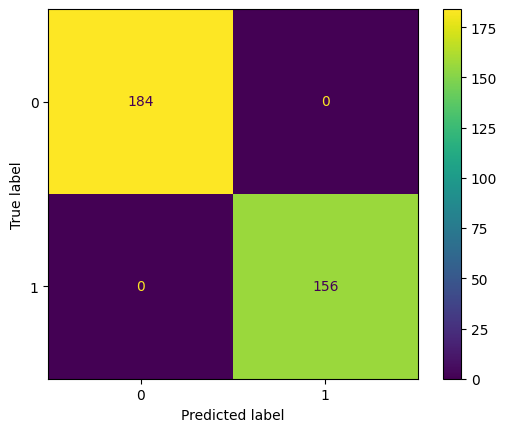

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

cm = confusion_matrix(y_test, yhat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

##Lista de modelos

In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
models = []
models.append(('LRG', LogisticRegression()))
models.append(('SVC', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models

nModels = len(models)
nModels

5

In [13]:
from scipy import stats
from scipy.stats.stats import mode
from sklearn.model_selection import (train_test_split, RepeatedKFold, RandomizedSearchCV)
from sklearn.pipeline import Pipeline

param_grids = []

param_grids.append( #LogisticRegression
    [
        {
            "LRG__C": stats.loguniform(1e-2, 1e2),
            "LRG__penalty": ["l1", "l2"],
            "LRG__solver": ["lbfgs","liblinear"],
        }
    ]
)

param_grids.append( #SVC
    [
        {
            "SVC__C": stats.loguniform(1e-1, 1e3),
            "SVC__kernel": ["linear", "rbf"],
            "SVC__gamma": stats.loguniform(1e-4, 1e0),
            #"SVC__epsilon": stats.loguniform(1e-4, 1e1),
        }
    ]
)

param_grids.append( #KNeighborsClassifier
    [
        {
            "KNN__n_neighbors": stats.randint(2, 100),
            "KNN__weights": ["uniform", "distance"],
            "KNN__algorithm": ["auto","ball_tree","kd_tree","brute"],
        }
    ]
)

param_grids.append( #DTC
    [
        {
            "DTC__criterion": ["gini", "entropy"],
            "DTC__splitter": ["best","random"],
            #"DTR__max_depth": stats.randint(2, 20),
            "DTC__max_features": stats.uniform(),
        }
    ]
)

param_grids.append( #RFC
    [
        {
            "RFC__n_estimators": stats.randint(2, 100),
            "RFC__criterion": ["gini", "entropy"],
            "RFC__max_depth": stats.randint(2, 20),
            "RFC__max_features": stats.uniform(),
        }
    ]
)

param_grids

<ipython-input-13-d74ede5d2950>:2: DeprecationWarning: Please import `mode` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import mode


[[{'LRG__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7942ff3b26e0>,
   'LRG__penalty': ['l1', 'l2'],
   'LRG__solver': ['lbfgs', 'liblinear']}],
 [{'SVC__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7942ff3b26b0>,
   'SVC__kernel': ['linear', 'rbf'],
   'SVC__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7942ff3b2a40>}],
 [{'KNN__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7942ff3b1ab0>,
   'KNN__weights': ['uniform', 'distance'],
   'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}],
 [{'DTC__criterion': ['gini', 'entropy'],
   'DTC__splitter': ['best', 'random'],
   'DTC__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7942ff3b3f70>}],
 [{'RFC__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7942ff3e1a50>,
   'RFC__criterion': ['gini', 'entropy'],
   'RFC__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x79

In [14]:
kfolds = 5
nkiter = 2 #50
n_search_iter = 2 #100

i = 0 #varia a reamostragem (caso seja necessário realizar Monte Carlo Cross-Validation)
#for i in range(nMcarlo):
#k = 0 #varia o modelo
for k in range(nModels):
  rkf = RepeatedKFold(n_splits=kfolds, n_repeats=nkiter, random_state=i)

  param_grid = param_grids[k]

  clf = Pipeline([
      ('scaler',StandardScaler()),
      ('pca', PCA(n_components=0.99)),
      (models[k])
      ])

  random_search = RandomizedSearchCV(
      estimator= clf,
      param_distributions= param_grid,
      n_iter = n_search_iter,
      scoring = "accuracy",
      n_jobs = -1,
      cv = rkf,
      random_state = i,
      verbose = 10)

  random_search.fit(X_train, y_train)

  yh_test = random_search.predict(X_test)
  print(yh_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[ True False False  True False False  True False  True  True  True False
  True  True False  True False False False  True False False False False
 False  True False  True False  True  True False  True  True False  True
  True  True False False  True False False False  True False  True  True
  True  True False False  True  True False  True  True False False  True
 False False  True  True  True False False  True False False False  True
 False  True  True False False  True  True False  True False False  True
 False  True False  True  True  True False  True  True  True False False
  True False False False  True  True  True False False  True  True  True
 False  True False False False  True False False False False False False
  True  True False False  True  True False False  True False False  True
  True False  True  True False False  True False False False False  True
 False  True  True False False False False False  True  True  T

In [15]:
random_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('RFC',
                 RandomForestClassifier(max_depth=17,
                                        max_features=0.7151893663724195,
                                        n_estimators=69))])

##K-means

In [16]:
from sklearn.cluster import KMeans

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(X_pca)

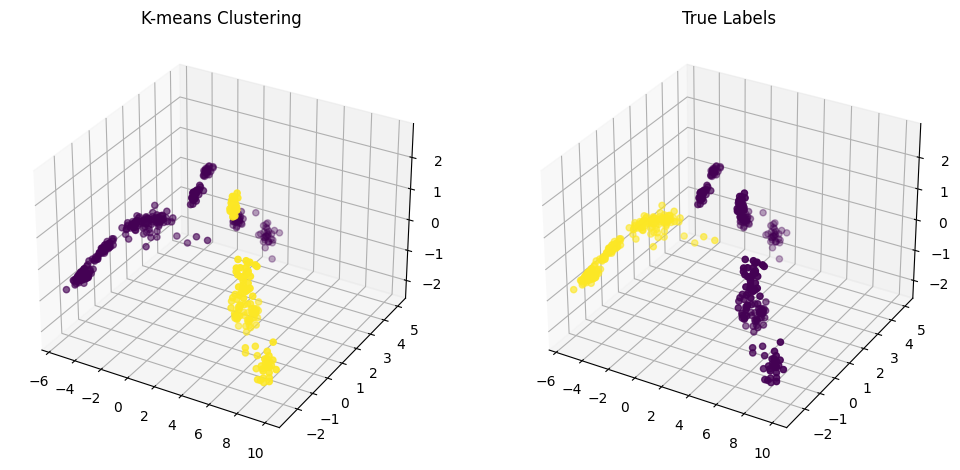

In [17]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans, cmap='viridis')
ax1.set_title('K-means Clustering')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='viridis')
ax2.set_title('True Labels')

plt.show()


##t-SNE

In [18]:
from sklearn.manifold import TSNE

###3d

In [19]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X1)

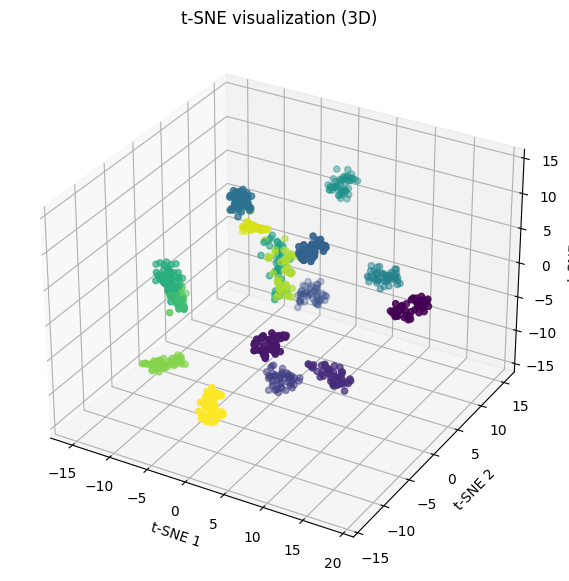

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('t-SNE visualization (3D)')

plt.show()

###3D PCA

In [21]:
pca_tsne = PCA(n_components=0.99)
X2 = pca_tsne.fit_transform(X1)
X_tsne_pca = tsne.fit_transform(X2)

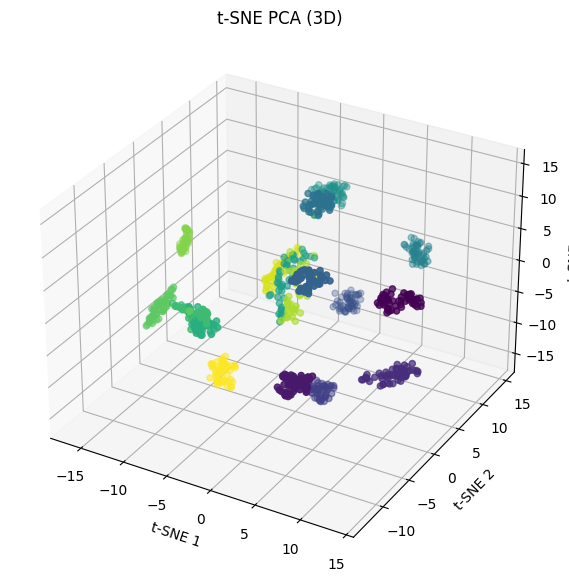

In [22]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], X_tsne_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('t-SNE PCA (3D)')

plt.show()

###2d

In [23]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X1)

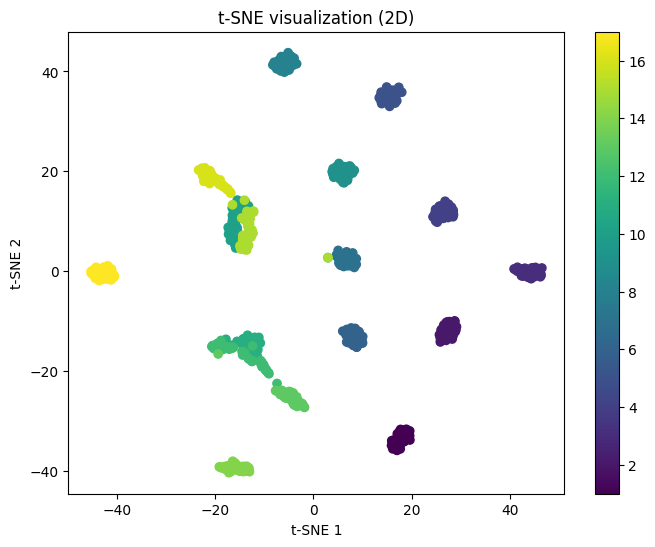

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE visualization (2D)')
plt.show()

###2D PCA

In [25]:
X_tsne_pca = tsne.fit_transform(X2)

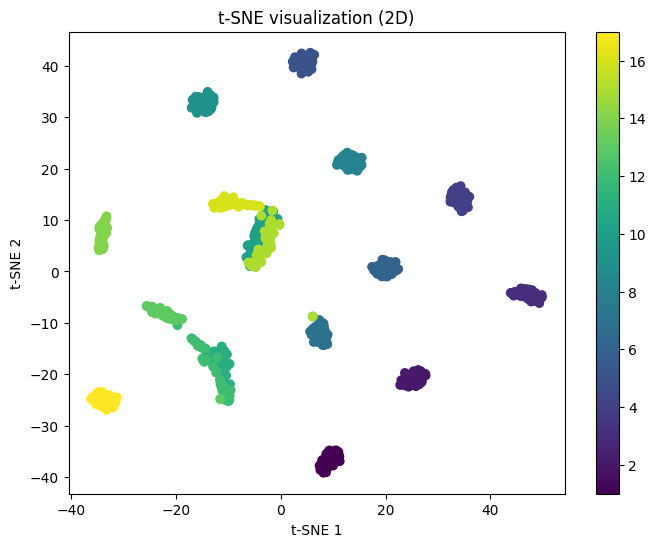

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE visualization (2D)')
plt.show()

##One-class classification

In [27]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto')
X_train_nominal = X_train[y_train <= 9]
clf.fit(X_train_nominal)

y_pred_test = clf.predict(X_test)
y_pred_test

array([ 1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,
        1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
        1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,
        1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,
        1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1,
       -1, -1,  1,  1, -1

In [28]:
clf.score_samples(X_test)

array([163.59232028, 158.62153788, 135.71195555, 156.53120677,
       145.30226963, 158.54695199, 168.29789128, 160.37786573,
       166.10443203, 171.65503978, 172.79533847, 160.1606036 ,
       168.51456509, 158.47257988, 146.1596287 , 160.86630792,
       161.06769032, 157.84997307, 160.33037814, 163.48326877,
       176.4461302 , 159.93519609, 146.88445008, 149.71246341,
       160.56719246, 156.63940019, 147.38289187, 163.63586004,
       175.02824147, 156.17478855, 168.78004599, 176.70346779,
       157.99709322, 156.99262854, 146.08077866, 157.30221618,
       168.09647071, 169.80434567, 163.47590924, 145.32959476,
       158.37357408, 159.82718667, 144.80314583, 152.47591247,
       167.00864605, 177.55487153, 163.46683819, 155.80840831,
       169.09560204, 172.87153093, 154.75182606, 157.79274254,
       165.25707039, 158.3073869 , 162.85503781, 156.17394114,
       163.46808252, 160.62832488, 161.61980193, 155.44881854,
       126.62049539, 160.53727488, 170.70834286, 157.73

In [29]:
y_pred_test = (y_pred_test == 1).astype(int)

In [30]:
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred_test))

Accuracy: 0.6029411764705882
Balanced Accuracy: 0.6034002229654403


#Aula 7

##Multiclass classification

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [34]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [38]:
model_ann = Sequential()
model_ann.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(units=64, activation='relu'))
model_ann.add(Dense(units=y_train_cat.shape[1], activation='softmax')) #Softmax para multiclass classif

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
from tensorflow.keras.optimizers import Adam

model_ann.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [40]:
history = model_ann.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat))

test_loss, test_accuracy = model_ann.evaluate(X_test, y_test_cat)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7544 - loss: 0.5329 - val_accuracy: 1.0000 - val_loss: 0.0792
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0502 - val_accuracy: 0.9971 - val_loss: 0.0212
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9942 - loss: 0.0284 - val_accuracy: 0.9971 - val_loss: 0.0119
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_los

In [41]:
y_pred_ann = model_ann.predict(X_test)
y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Text(0.5, 1.0, 'Confusion Matrix - ANN')

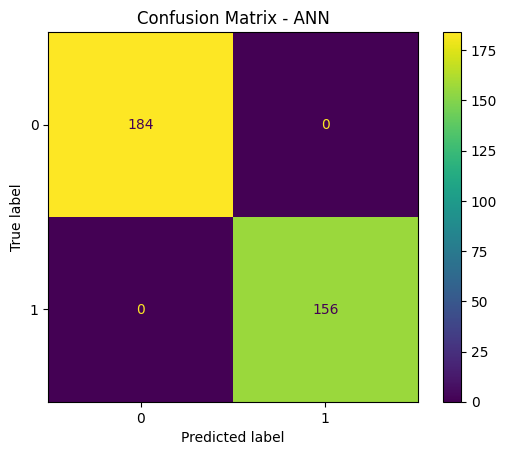

In [42]:
cm_ann = confusion_matrix(y_test, y_pred_ann_classes)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann)
disp_ann.plot()
plt.title('Confusion Matrix - ANN')

In [44]:
acc_ann = accuracy_score(y_test, y_pred_ann_classes)
balanced_acc_ann = balanced_accuracy_score(y_test, y_pred_ann_classes)
print(f'ANN Acurácia: {acc_ann}')
print(f'ANN Acurácia balanceada: {balanced_acc_ann}')

ANN Acurácia: 1.0
ANN Acurácia balanceada: 1.0


De acordo com os resultados obtidos através das redes neurais, é possível afirmar que o modelo obteve um ótimo resultado para o conjunto de dados, visto que classificou corretamente 100% das amostras. Porém, isso também se deve ao fato de não ser um problema muito complexo, já que foi resolvido com facilidade pelo modelo softmax apresentado na aula 2.